## This notebook presents and explains all steps of the TEAM method 
It serves as a quick-guide to familiarize with the developed method.

In [1]:
# imports
from pathlib import Path

import numpy as np

from team.aligned_trajectories import AlignedTrajectories
from team.dynamical_movement_primitives import DynamicMovementPrimitives
from team.gaussian_mixture_regression import GMR
from team.probabilistic_encoding import ProbabilisticEncoding
from team.utility.dmp_visualization import plotting
from team.utility.gmm_visualization import plot_gmm, plot_js_distance, plot_confidence
from rws2.RWS2 import RWS

In [2]:
# data loading 
task_name = "opening"
data_dir = Path.cwd().parent.joinpath(f"data/learning_from_demonstrations/{task_name}")

### The dataset is loaded and preprocessed
Steps
- DTW for temporal alignment 
- resampling to same frequency 
- padding to same lenght 

In [5]:
# data preprocessing 
trajectories = AlignedTrajectories.load_dataset_and_preprocess(str(data_dir))

23:27:48-INFO-dtw.py-distance_matrix -> Computing distances
23:27:48-INFO-dtw.py-distance_matrix -> Compute distances in C (parallel=OMP)


### Gaussian mixture modeling
The aligned trajectories are fitted with GMMs. `max_nb_components`, `min_nb_components` and `iterations` arguments serve to define the range where the Jensen-Shannon divergence distance and the associated statistics are computed to select the optimal number of GMM compoenents K.

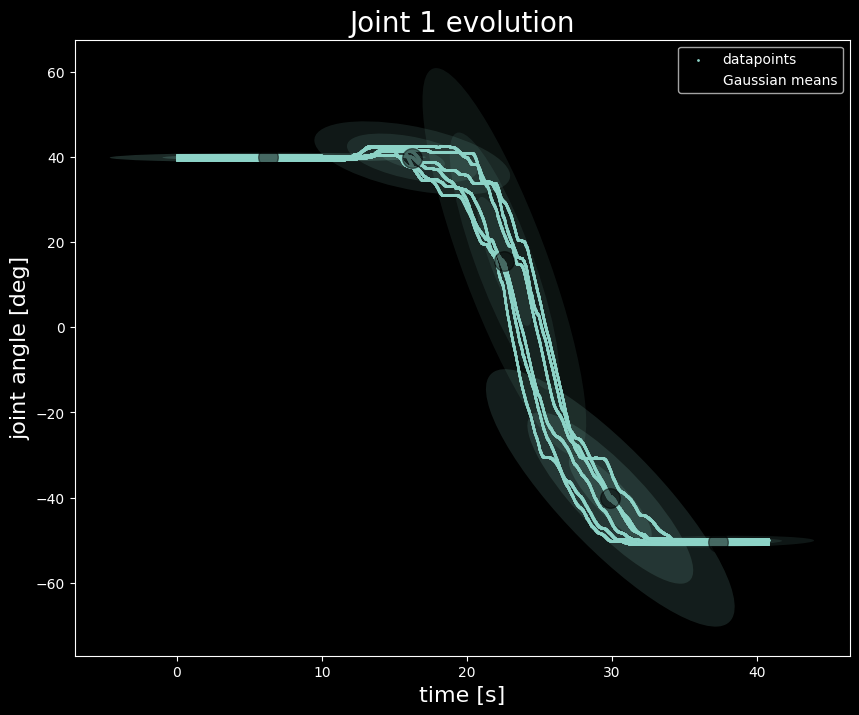

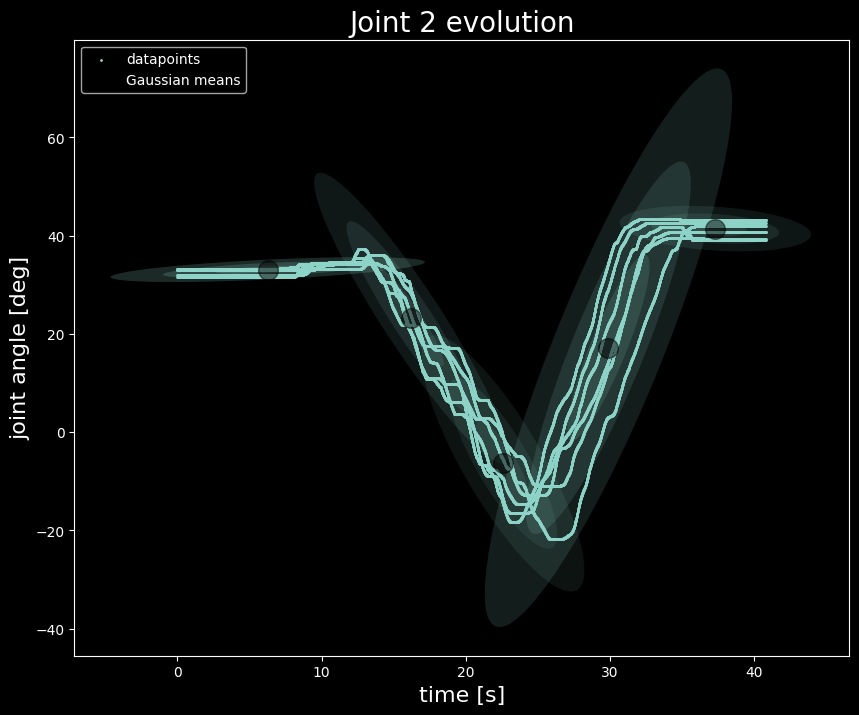

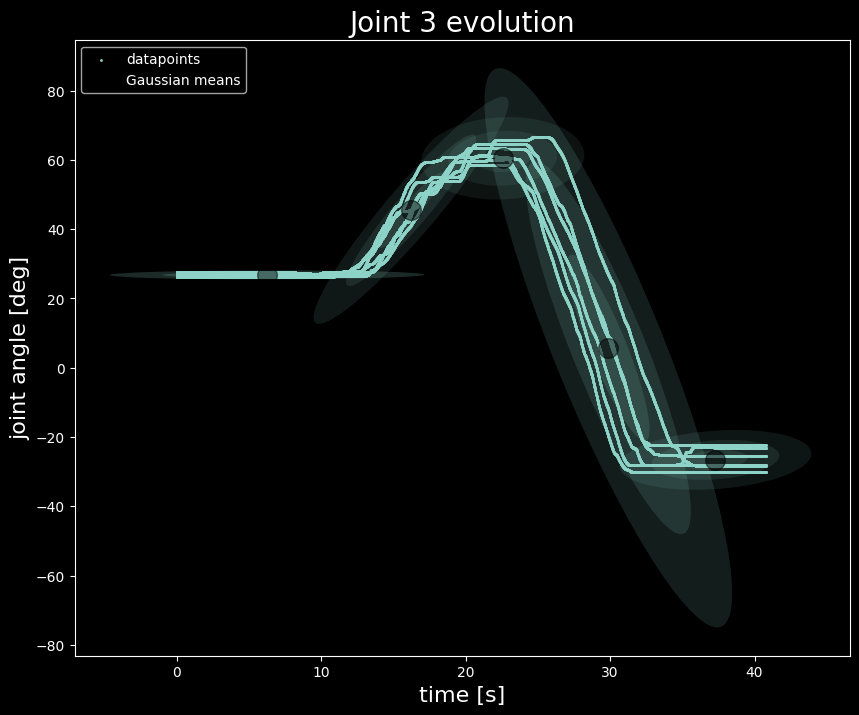

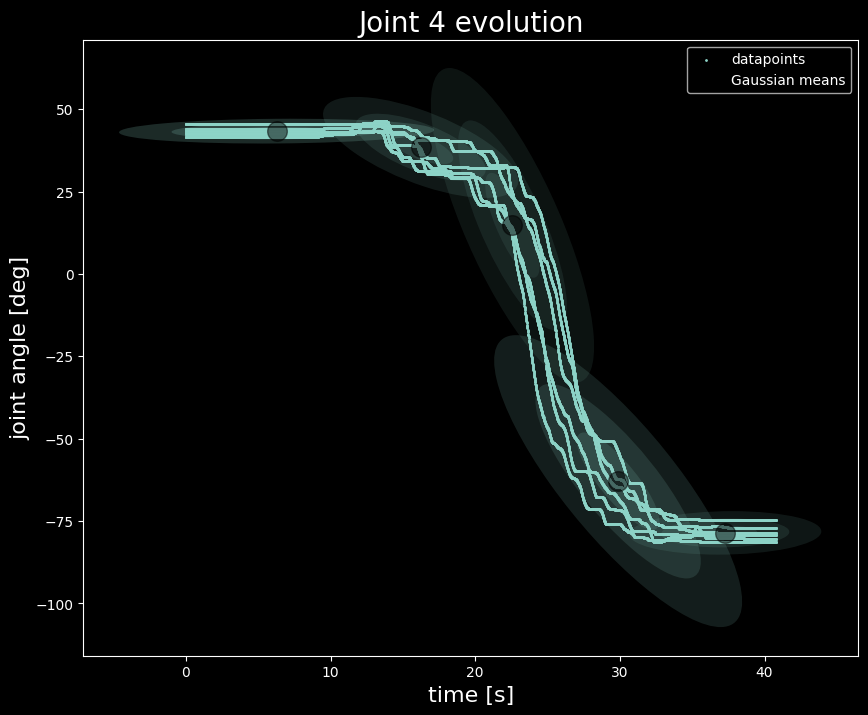

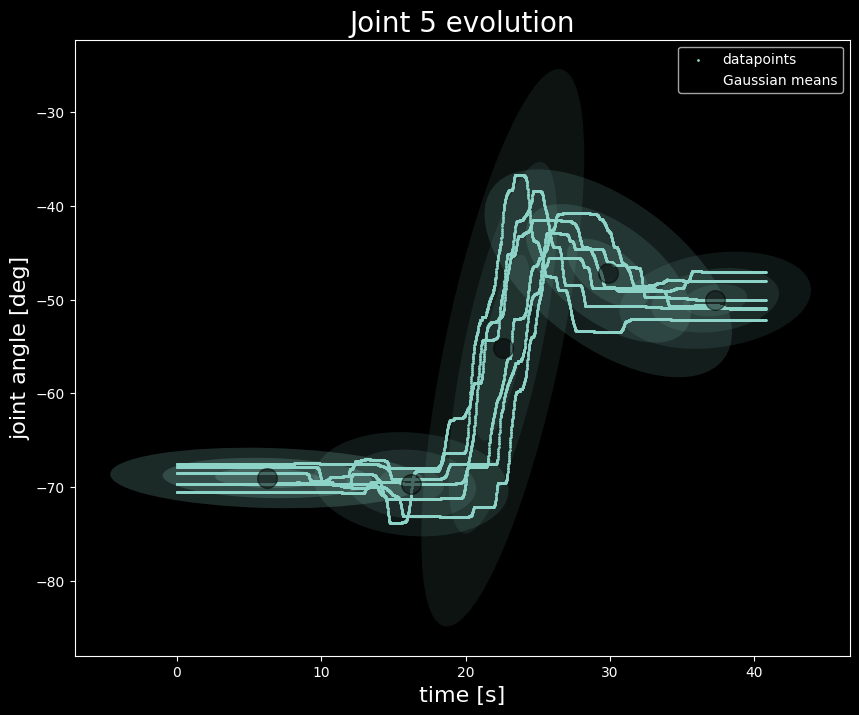

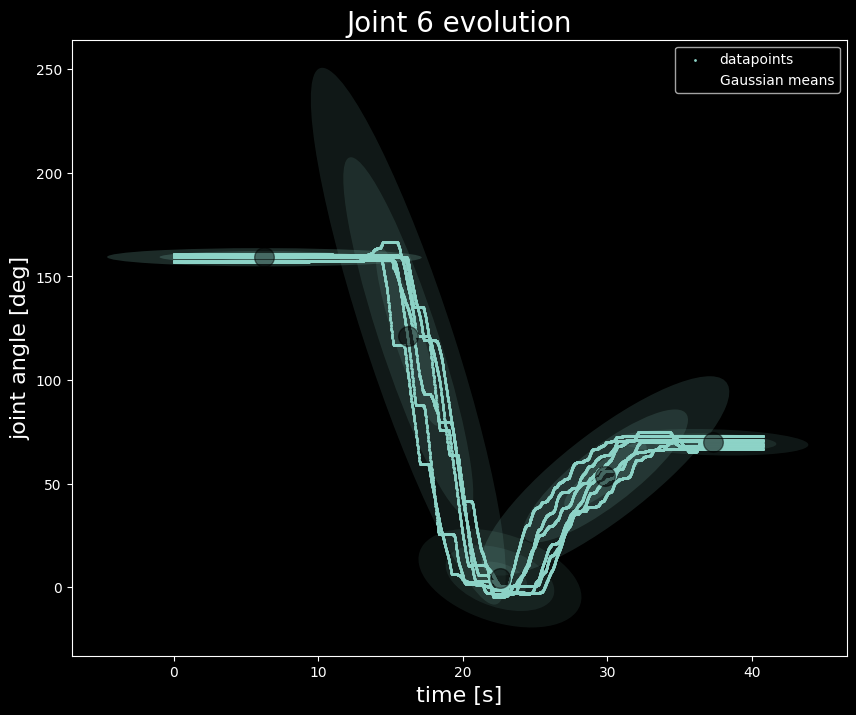

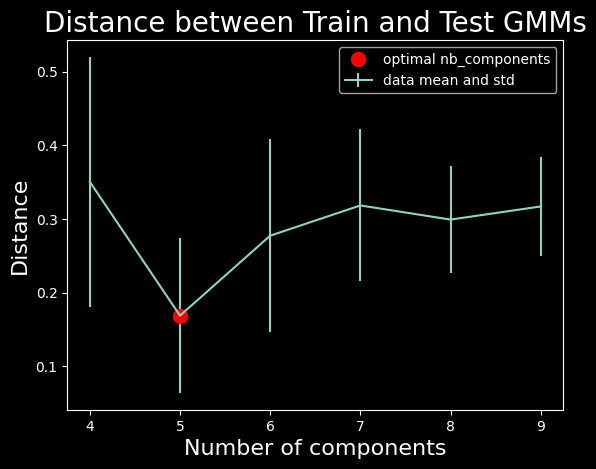

In [6]:
# GMM
pe = ProbabilisticEncoding(trajectories, max_nb_components=10, min_nb_components=4, iterations=10)
plot_gmm(pe)
plot_js_distance(pe, max_nb_components=10, min_nb_components=4)

### Gaussian mixture regression
Computes the regression line over the probabilist encoding

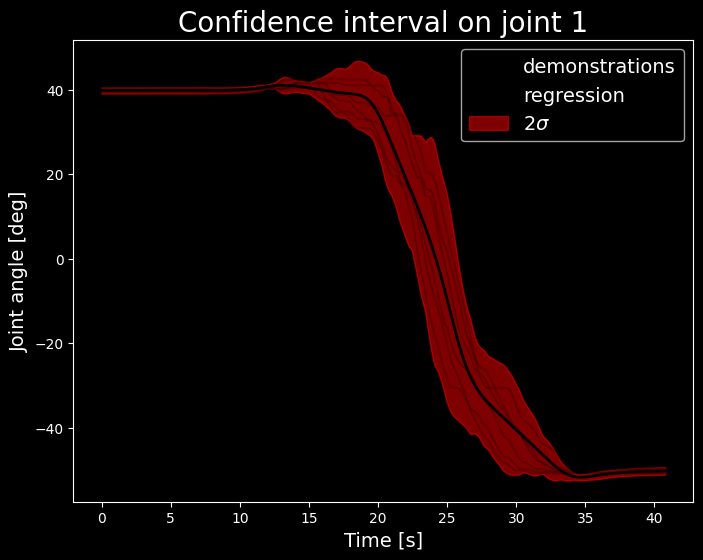

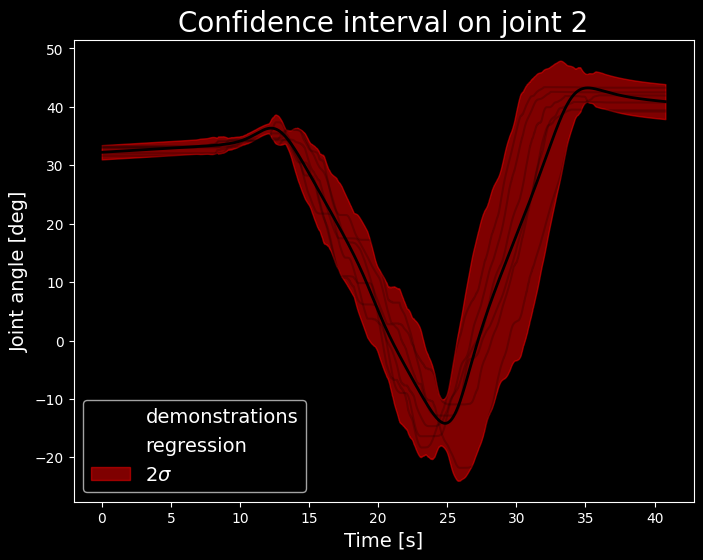

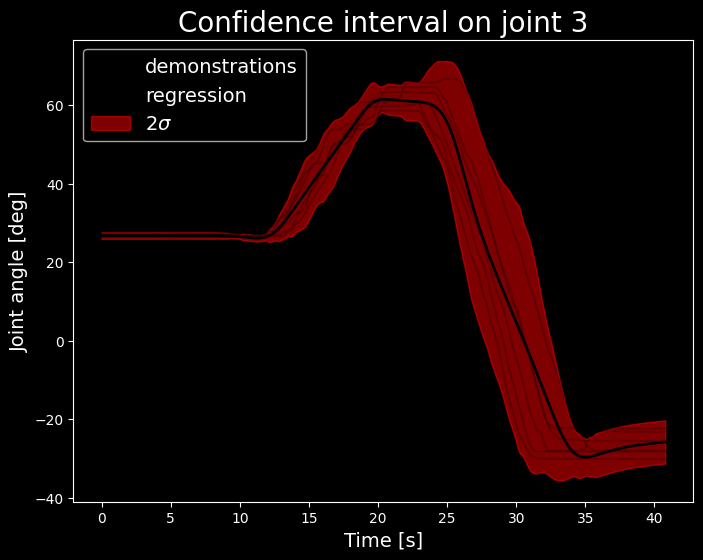

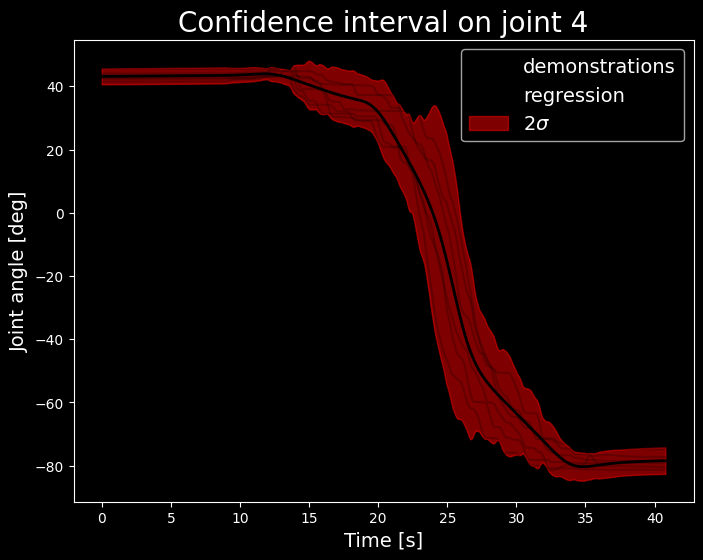

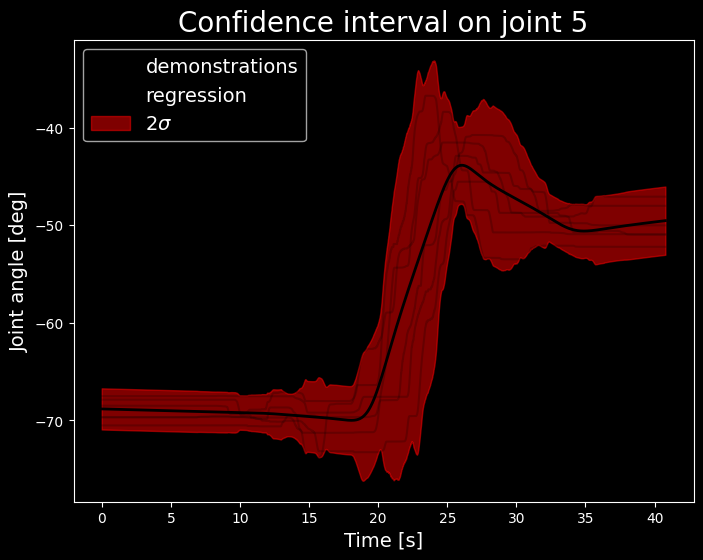

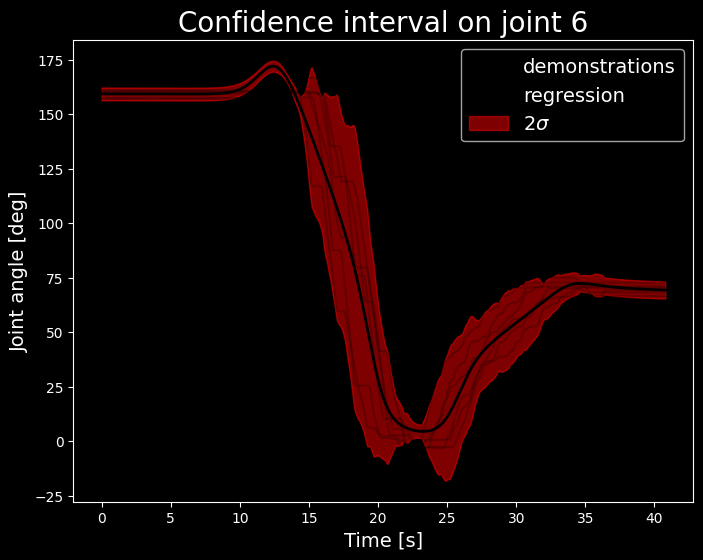

In [7]:
# GMR
regression = GMR(trajectories, pe)
plot_confidence(trajectories.timestamps, trajectories.joints_trajectories, regression.prediction)

### Dynamic movement primitives 
`target` and `initial_state` are here defined as the starting and end joint positions of the regression line. The optimal damped spring model parameters are found through Bayesian optimization, then the trajectory is generated. 

c:\Users\miellema\Miniconda3\envs\team2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\miellema\Miniconda3\envs\team2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


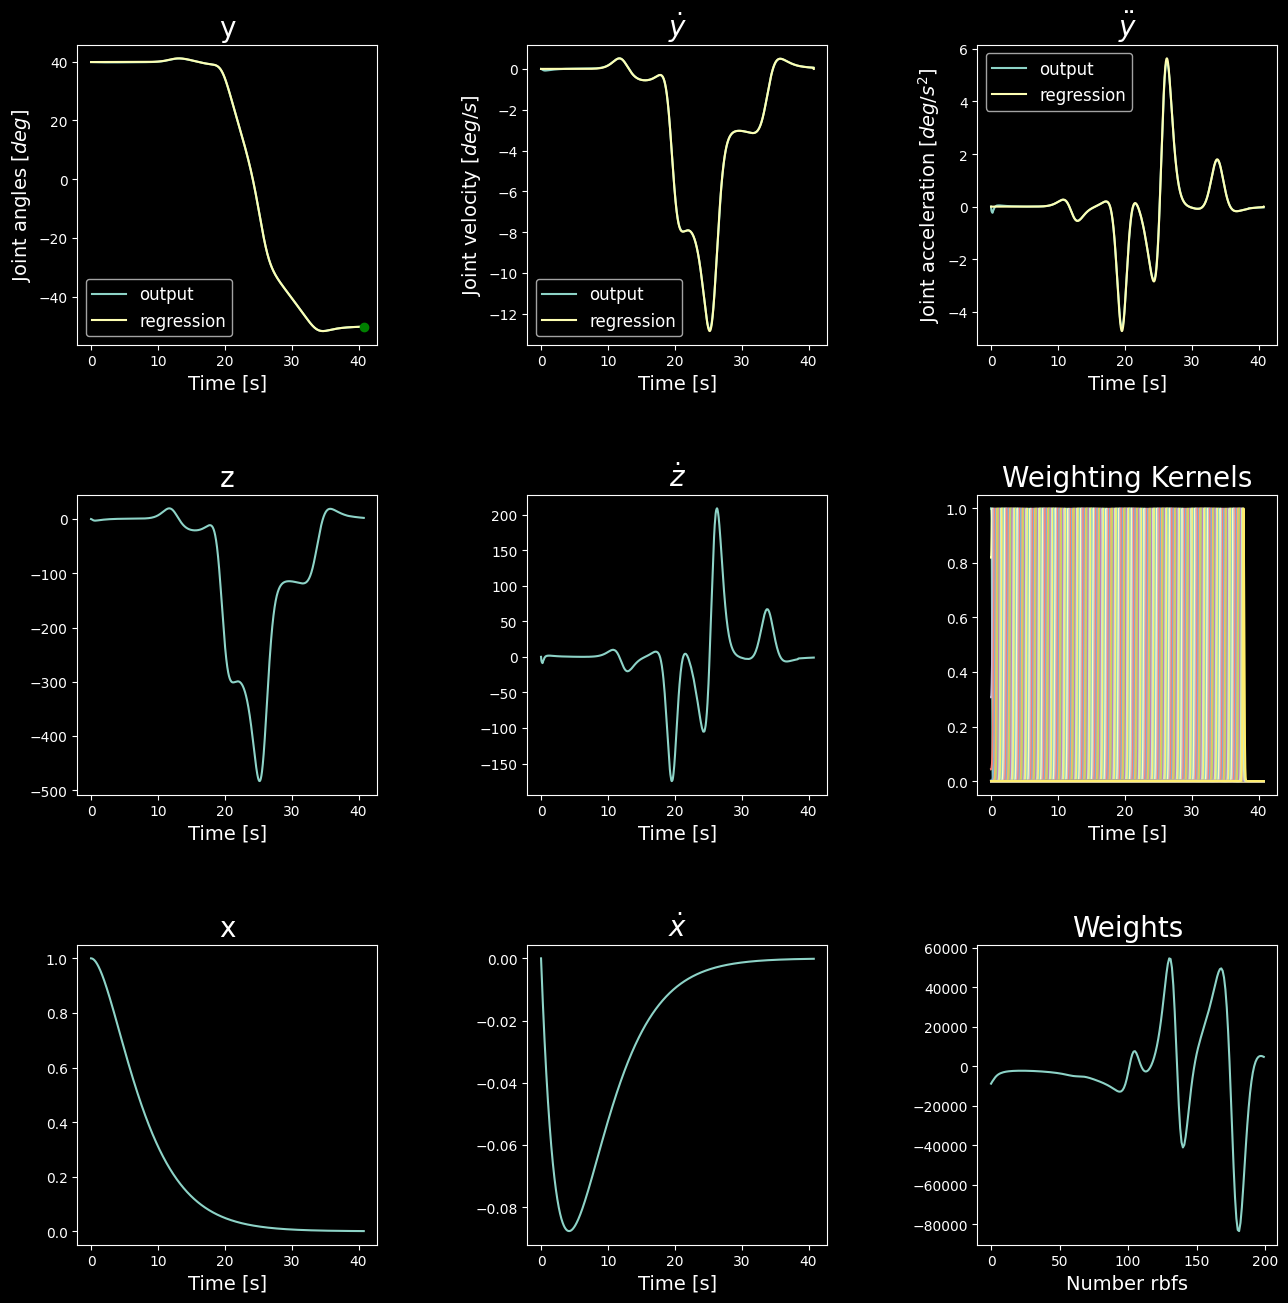

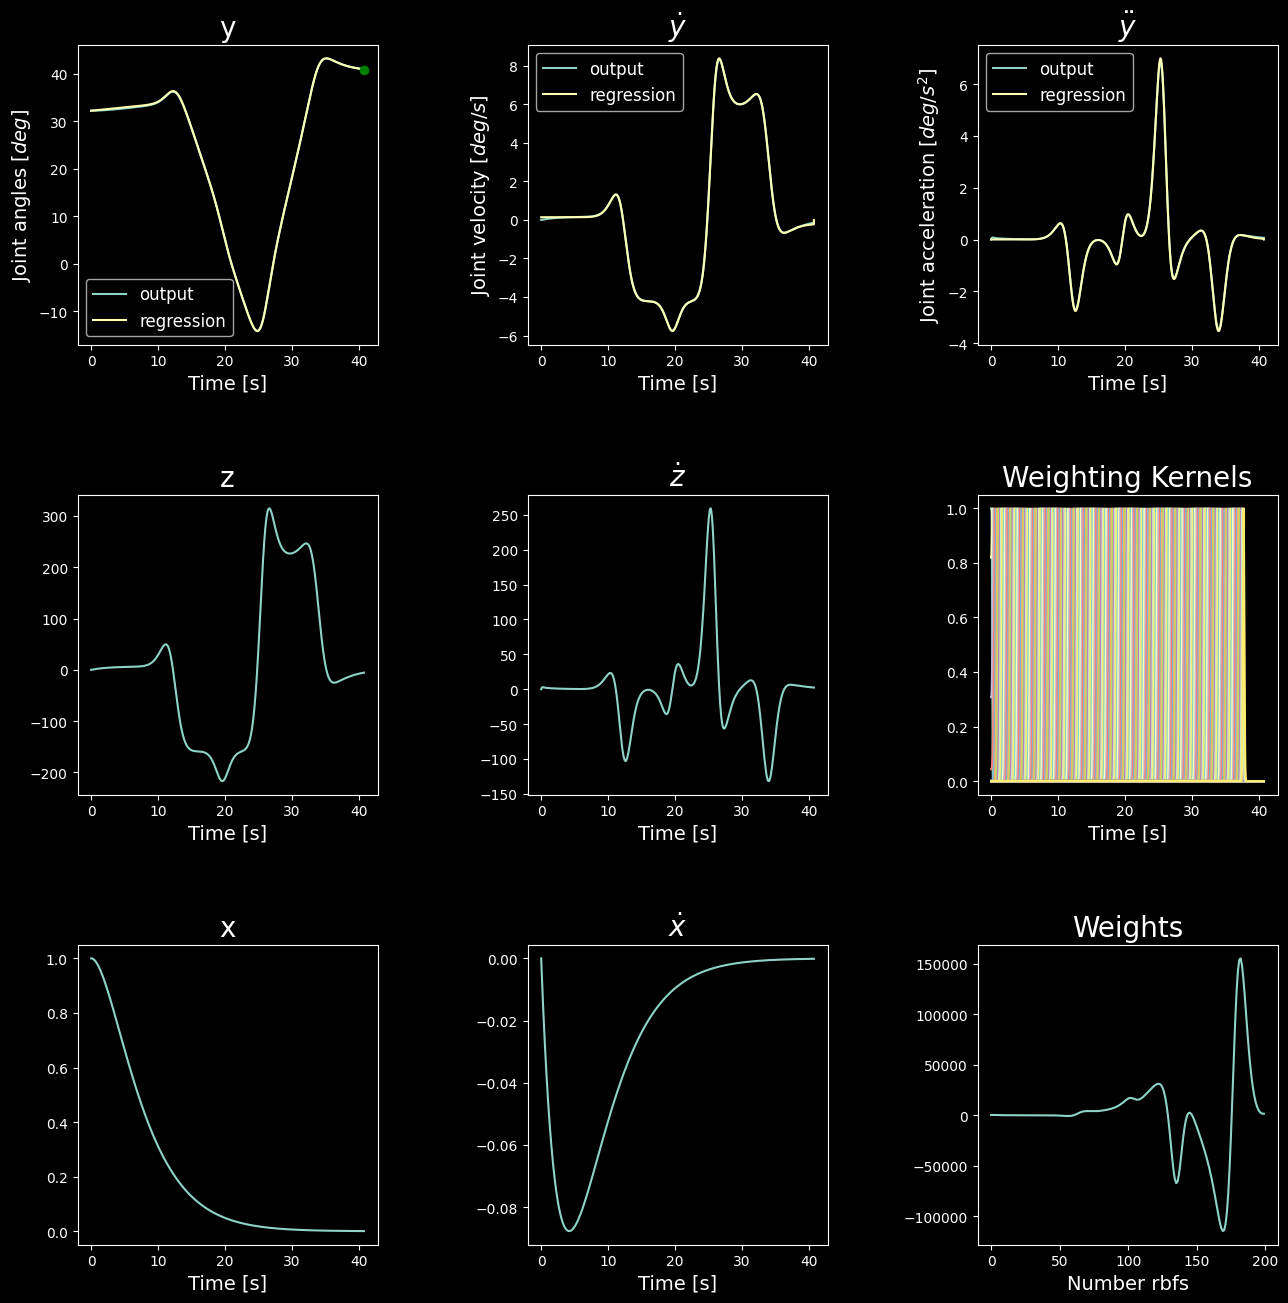

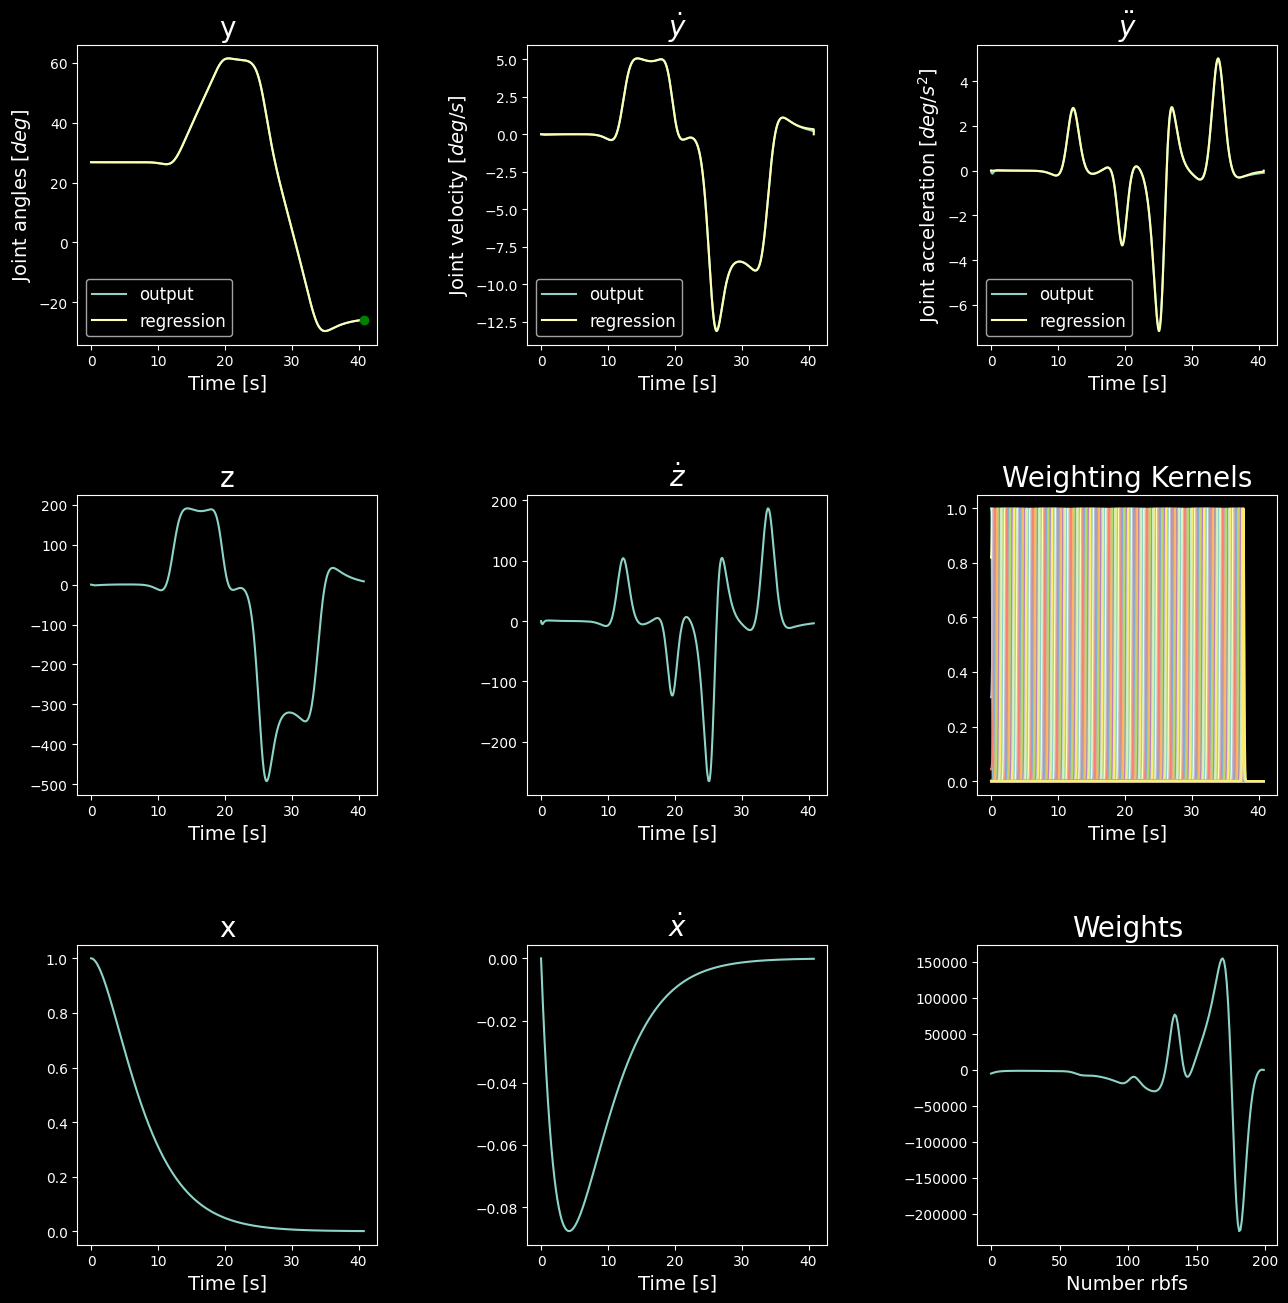

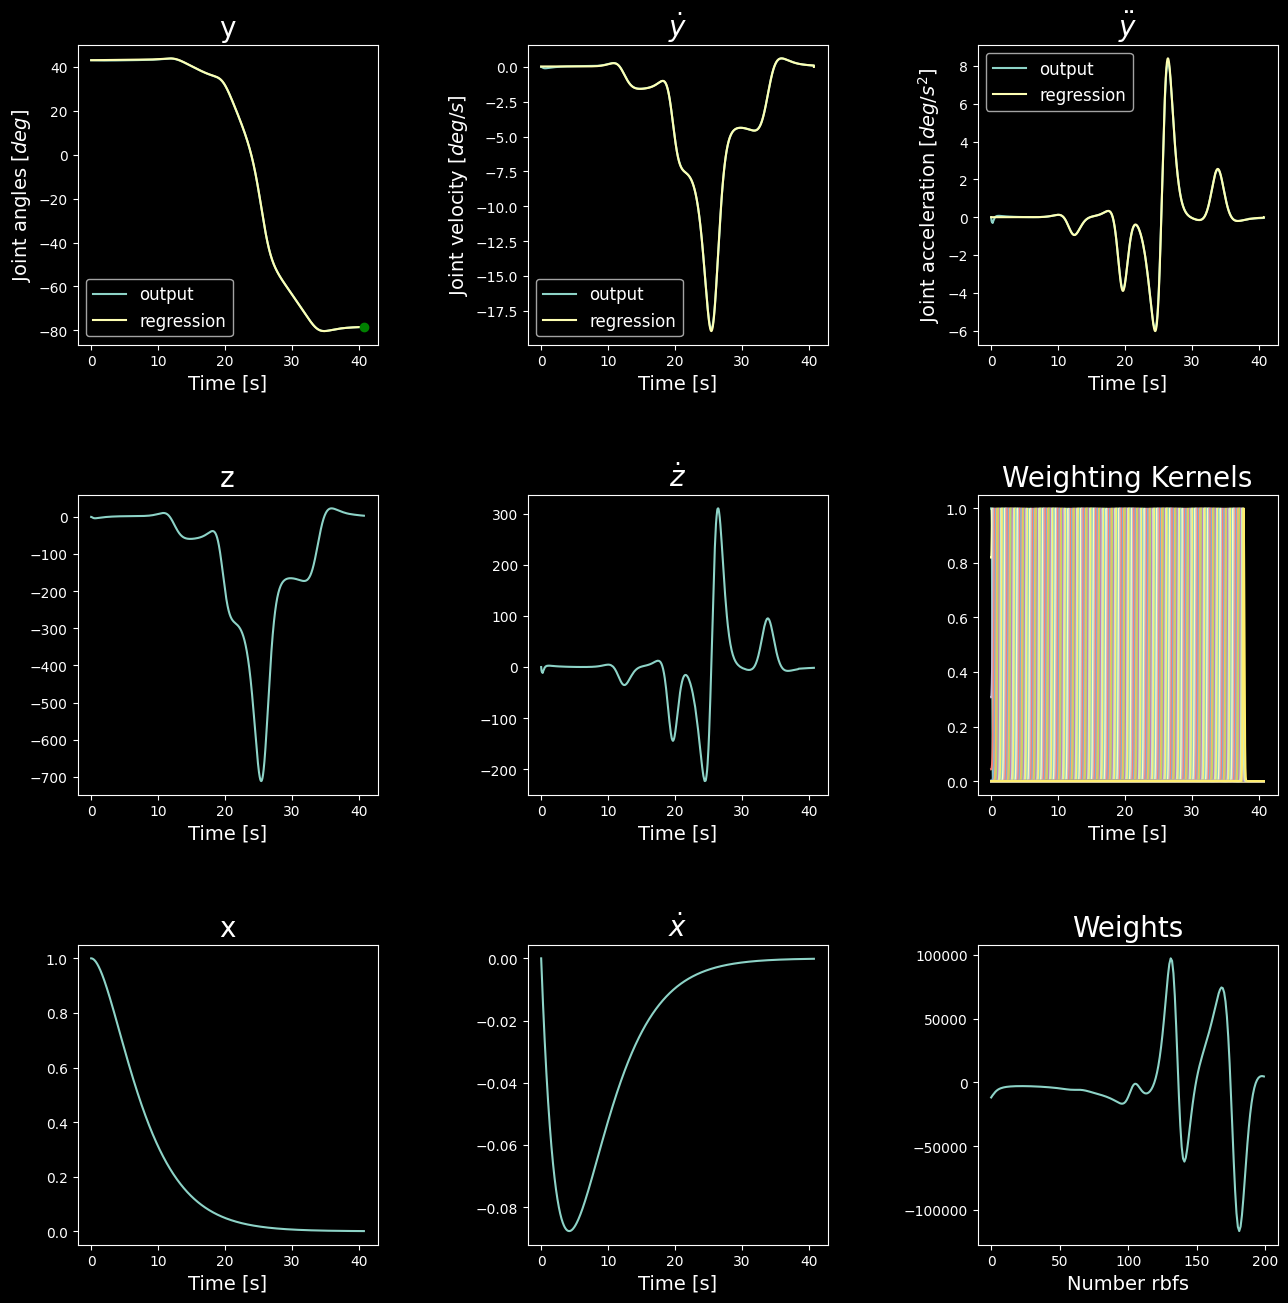

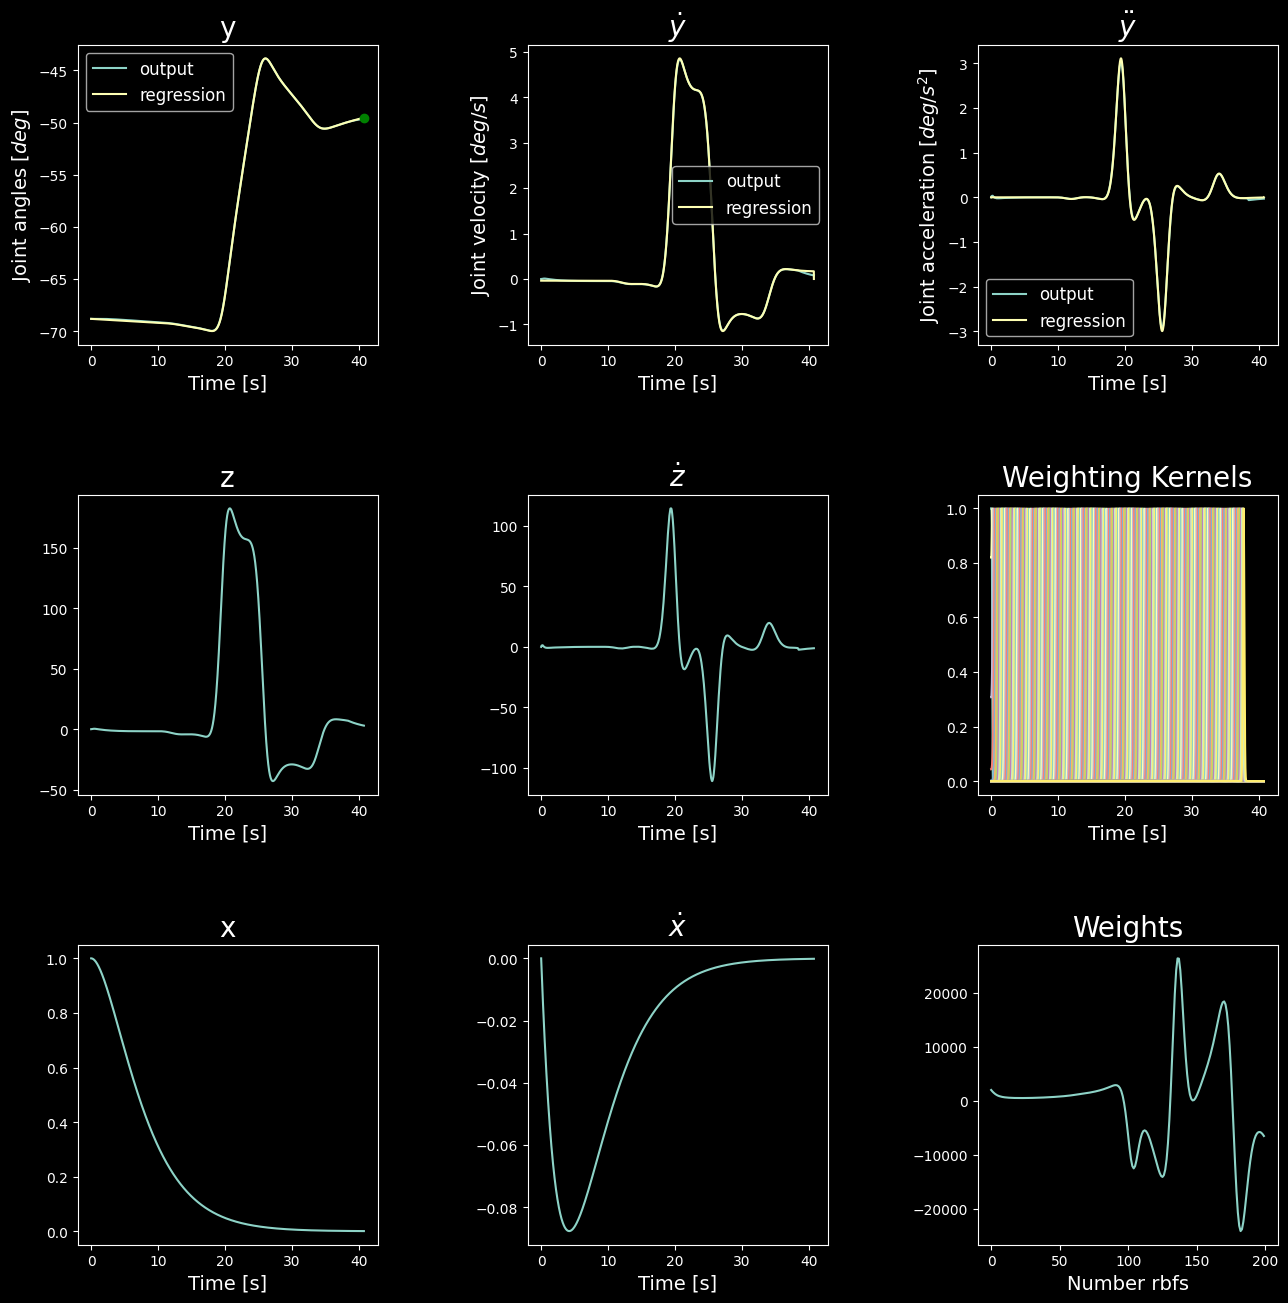

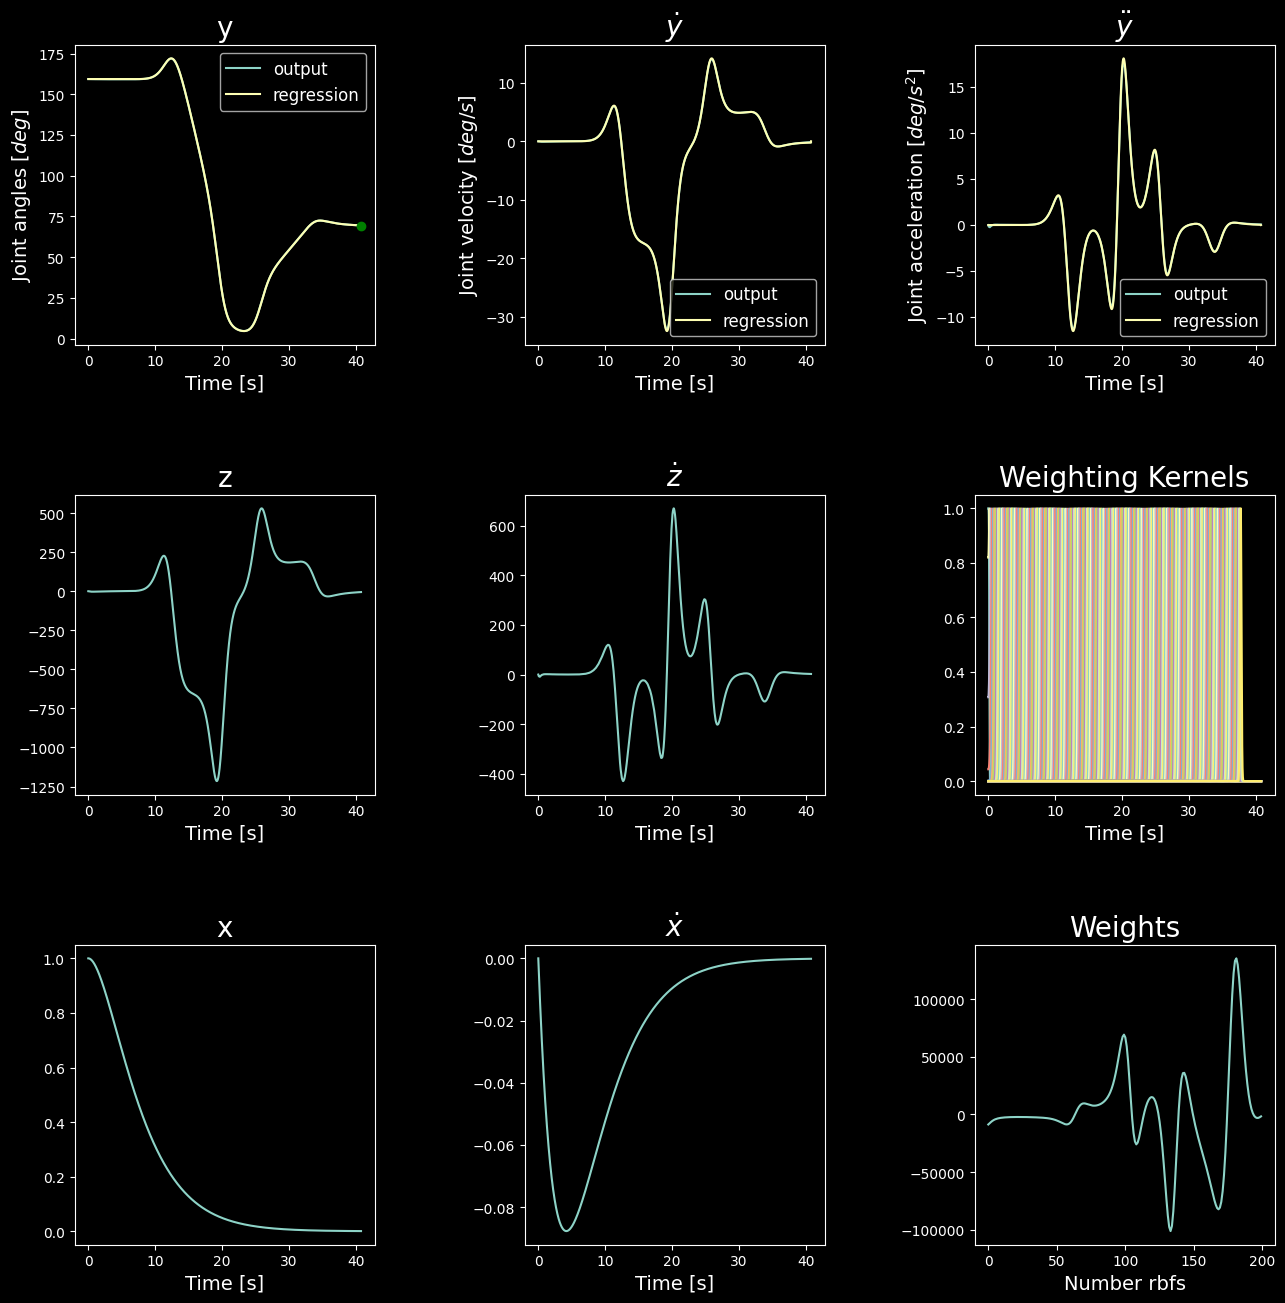

In [8]:
# DMP
target = regression.prediction[-1, 1:]
initial_state = regression.prediction[0, 1:]
dmp = DynamicMovementPrimitives(
    regression=regression.prediction,
    c_order=1,
    initial_joints=initial_state,
    goal_joints=target,
)
dmp_traj = dmp.compute_joint_dynamics(goal=target, y_init=initial_state)
plotting(dmp)

### Store model parameters to file 

In [9]:
# save model parameters 
store_path = Path.cwd().joinpath(f"tmp/{task_name}")
store_path.parent.mkdir()
dmp.save_dmp(dir_path=store_path)

### Send computed trajectory to controller for execution
This step requires to have a virtual controller running on RobotStudio and listening to port 8881 or a physicalconnection to the ABB GoFa robot -> in this latter case please change url to https://192.168.125.1

In [8]:
# send trajectory to controller
text = dmp_traj.joints_to_string()
rws = RWS("https://localhost:8881")
rws.upload_text_file_to_controller(
    text_data=text, filename=f"{task_name}.txt"
)

ConnectionError: HTTPSConnectionPool(host='localhost', port=8881): Max retries exceeded with url: /fileservice/data/opening.txt (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001E2CA9B46A0>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))